# Library Importation

In [1]:
import os
import requests
import json
from pymongo import MongoClient
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt


# Data Aquizition
json data files and loading to mongo db

In [2]:
# MongoDB Configuration
MONGO_URI = "mongodb://localhost:27017"
DATABASE_NAME = "PublicHealthCrimeData"

# URLs of datasets
DATASETS = {
    "DrugOverdose": "https://data.cdc.gov/api/views/95ax-ymtc/rows.json?accessType=DOWNLOAD",
    "LifeExpectancy": "https://data.cdc.gov/api/views/5h56-n989/rows.json?accessType=DOWNLOAD",
    "CrimeData": "https://data.lacity.org/api/views/2nrs-mtv8/rows.json?accessType=DOWNLOAD"
}

def download_json(dataset_name, url):
    """
    Downloads the dataset in JSON format from the provided URL.
    """
    print(f"Processing {dataset_name}...")
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        print(f"{dataset_name} dataset downloaded successfully.")
        return data
    except Exception as e:
        print(f"Failed to download {dataset_name}: {e}")
        return None

def load_data_to_mongodb(dataset_name, data, collection_name):
    """
    Loads JSON data into MongoDB collection.
    """
    try:
        # Connect to MongoDB
        client = MongoClient(MONGO_URI)
        db = client[DATABASE_NAME]
        collection = db[collection_name]

        # Determine structure of data
        if isinstance(data, dict) and 'data' in data and 'meta' in data:
            # Assuming the structure has "meta" for headers and "data" for rows
            headers = [column['name'] for column in data['meta']['view']['columns']]
            rows = data['data']

            # Convert rows to dictionaries using headers
            documents = [dict(zip(headers, row)) for row in rows]
        else:
            raise ValueError("Unexpected JSON structure")

        # Insert documents into MongoDB
        collection.insert_many(documents)
        print(f"Data from {dataset_name} loaded into MongoDB collection {collection_name} successfully.")

    except Exception as e:
        print(f"Failed to load data into MongoDB for {dataset_name}: {e}")

def main():
    for dataset_name, url in DATASETS.items():
        # Download the dataset in JSON format
        data = download_json(dataset_name, url)

        if data:
            # Load into MongoDB
            load_data_to_mongodb(dataset_name, data, dataset_name)

if __name__ == "__main__":
    main()


Processing DrugOverdose...
DrugOverdose dataset downloaded successfully.
Data from DrugOverdose loaded into MongoDB collection DrugOverdose successfully.
Processing LifeExpectancy...
LifeExpectancy dataset downloaded successfully.
Data from LifeExpectancy loaded into MongoDB collection LifeExpectancy successfully.
Processing CrimeData...
CrimeData dataset downloaded successfully.
Data from CrimeData loaded into MongoDB collection CrimeData successfully.


# Transforming the data into a structured Format
Loading the CSVs Into SQLITE Database

In [ ]:
# MongoDB Configuration
MONGO_URI = "mongodb://localhost:27017"
DATABASE_NAME = "PublicHealthCrimeData"

# SQLite Database Path
DB_PATH = "C:/Users/Sheila/Downloads/final project 1/PublicHealthCrimeData2.db"

# Directory to store CSV files
CSV_DIR = "C:/Users/Sheila/Downloads/final project 1/csv_files"


def read_data_from_mongo(collection_name):
    """
    Reads data from a specified MongoDB collection and returns it as a pandas DataFrame.
    """
    client = MongoClient(MONGO_URI)
    db = client[DATABASE_NAME]
    collection = db[collection_name]

    # Fetch data from MongoDB
    data = list(collection.find({}))

    # Convert to DataFrame
    df = pd.DataFrame(data)
    print(f"Loaded {len(df)} rows from MongoDB collection {collection_name}.")
    return df

def save_dataframe_as_csv(df, file_name):
    """
    Saves a pandas DataFrame as a CSV file.
    """
    file_path = f"{CSV_DIR}/{file_name}.csv"
    df.to_csv(file_path, index=False)
    print(f"Saved DataFrame to {file_path}.")
    return file_path


def load_csv_to_sqlite(file_path, table_name):
    """
    Loads data from a CSV file into an SQLite database table.
    """
    conn = sqlite3.connect(DB_PATH)
    try:
        # Read CSV into pandas DataFrame
        df = pd.read_csv(file_path)

        # Save to SQLite
        df.to_sql(table_name, conn, if_exists='replace', index=False)
        print(f"Loaded data from {file_path} into SQLite table {table_name}.")
    finally:
        conn.close()


if __name__ == "__main__":
    import os
    os.makedirs(CSV_DIR, exist_ok=True)  # Ensure the CSV directory exists

    # MongoDB collections to process
    collections = ["DrugOverdose", "LifeExpectancy", "CrimeData"]

    for collection_name in collections:
        print(f"Processing {collection_name}...")
        # Step 1: Read data from MongoDB
        data = read_data_from_mongo(collection_name)

        # Step 2: Save as CSV
        csv_file_path = save_dataframe_as_csv(data, collection_name)

        # Step 3: Load into SQLite
        load_csv_to_sqlite(csv_file_path, collection_name)


Processing DrugOverdose...
Loaded 18684 rows from MongoDB collection DrugOverdose.
Saved DataFrame to C:/Users/Sheila/Downloads/final project 1/csv_files/DrugOverdose.csv.
Loaded data from C:/Users/Sheila/Downloads/final project 1/csv_files/DrugOverdose.csv into SQLite table DrugOverdose.
Processing LifeExpectancy...
Loaded 219363 rows from MongoDB collection LifeExpectancy.
Saved DataFrame to C:/Users/Sheila/Downloads/final project 1/csv_files/LifeExpectancy.csv.
Loaded data from C:/Users/Sheila/Downloads/final project 1/csv_files/LifeExpectancy.csv into SQLite table LifeExpectancy.
Processing CrimeData...


# Data PreProcessing

In [1]:
# Database path
DB_PATH = "C:/Users/Sheila/Downloads/final project 1/PublicHealthCrimeData2.db"

def read_data_from_db(table_name):
    """
    Reads data from a specified SQLite table and returns it as a pandas DataFrame.
    """
    conn = sqlite3.connect(DB_PATH)
    try:
        query = f"SELECT * FROM {table_name}"
        data = pd.read_sql_query(query, conn)
        print(f"Loaded {len(data)} rows from {table_name}.")
        return data
    finally:
        conn.close()

def preprocess_drug_overdose_data(df):
    """
    Preprocesses the DrugOverdose dataset.
    """
    # Convert YEAR to datetime
   # df['YEAR'] = pd.to_datetime(df['YEAR'], format='%Y', errors='coerce')

    # Drop rows with missing or invalid values
    df = df.dropna(subset=['YEAR', 'ESTIMATE'])

    # Convert ESTIMATE to numeric
    df['ESTIMATE'] = pd.to_numeric(df['ESTIMATE'], errors='coerce')

    print(f"Preprocessed DrugOverdose dataset: {len(df)} rows remaining.")
    return df

def preprocess_life_expectancy_data(df):
    """
    Preprocesses the LifeExpectancy dataset.
    """
    # Drop rows with missing Life Expectancy
    df = df.dropna(subset=['Life Expectancy'])

    # Convert Life Expectancy to numeric
    df['Life Expectancy'] = pd.to_numeric(df['Life Expectancy'], errors='coerce')

    print(f"Preprocessed LifeExpectancy dataset: {len(df)} rows remaining.")
    return df

def preprocess_crime_data(df):
    """
    Preprocesses the CrimeData dataset.
    """
    # Verify if the required date column exists
    date_column = 'DATE OCC'  # Assuming 'DATE OCC' is the intended column
    if date_column not in df.columns:
        raise KeyError(f"'{date_column}' column not found in CrimeData dataset.")

    # Convert DATE OCC to datetime with specified format
    date_format = '%m/%d/%Y %I:%M:%S %p'
    df[date_column] = pd.to_datetime(df[date_column], format=date_format, errors='coerce')

    # Drop rows with missing DATE OCC or invalid values
    #df = df.dropna(subset=[date_column])

    print(f"Preprocessed CrimeData dataset: {len(df)} rows remaining.")
    return df


if __name__ == "__main__":
    # Read and preprocess datasets
    drug_overdose_data = preprocess_drug_overdose_data(read_data_from_db("DrugOverdose"))
    life_expectancy_data = preprocess_life_expectancy_data(read_data_from_db("LifeExpectancy"))
    crime_data = preprocess_crime_data(read_data_from_db("CrimeData"))

    # Save preprocessed data for later usage
    drug_overdose_data.to_csv("drug_overdose_preprocessed.csv", index=False)
    life_expectancy_data.to_csv("life_expectancy_preprocessed.csv", index=False)
    crime_data.to_csv("crime_data_preprocessed.csv", index=False)

Loaded 6228 rows from DrugOverdose.
Preprocessed DrugOverdose dataset: 5117 rows remaining.
Loaded 73121 rows from LifeExpectancy.
Preprocessed LifeExpectancy dataset: 67199 rows remaining.
Loaded 1003448 rows from CrimeData.
Preprocessed CrimeData dataset: 1003448 rows remaining.


# Loading processed data into sqllite

In [2]:
# Database path
DB_PATH = "PublicHealthCrimeData.db"

def read_data_from_db(table_name):
    """
    Reads data from a specified SQLite table and returns it as a pandas DataFrame.
    """
    conn = sqlite3.connect(DB_PATH)
    try:
        query = f"SELECT * FROM {table_name}"
        data = pd.read_sql_query(query, conn)
        print(f"Loaded {len(data)} rows from {table_name}.")
        return data
    finally:
        conn.close()

def preprocess_drug_overdose_data(df):
    """
    Preprocesses the DrugOverdose dataset.
    """
    # Convert YEAR to datetime
   # df['YEAR'] = pd.to_datetime(df['YEAR'], format='%Y', errors='coerce')

    # Drop rows with missing or invalid values
    df = df.dropna(subset=['YEAR', 'ESTIMATE'])

    # Convert ESTIMATE to numeric
    df['ESTIMATE'] = pd.to_numeric(df['ESTIMATE'], errors='coerce')

    print(f"Preprocessed DrugOverdose dataset: {len(df)} rows remaining.")
    return df

def preprocess_life_expectancy_data(df):
    """
    Preprocesses the LifeExpectancy dataset.
    """
    # Drop rows with missing Life Expectancy
    df = df.dropna(subset=['Life Expectancy'])

    # Convert Life Expectancy to numeric
    df['Life Expectancy'] = pd.to_numeric(df['Life Expectancy'], errors='coerce')

    print(f"Preprocessed LifeExpectancy dataset: {len(df)} rows remaining.")
    return df

def preprocess_crime_data(df):
    """
    Preprocesses the CrimeData dataset.
    """
    # Verify if the required date column exists
    date_column = 'DATE OCC'  # Assuming 'DATE OCC' is the intended column
    if date_column not in df.columns:
        raise KeyError(f"'{date_column}' column not found in CrimeData dataset.")

    # Convert DATE OCC to datetime with specified format
    date_format = '%m/%d/%Y %I:%M:%S %p'
    df[date_column] = pd.to_datetime(df[date_column], format=date_format, errors='coerce')

    # Drop rows with missing DATE OCC or invalid values
    df = df.dropna(subset=[date_column])

    print(f"Preprocessed CrimeData dataset: {len(df)} rows remaining.")
    return df


if __name__ == "__main__":
    # Read and preprocess datasets
    drug_overdose_data = preprocess_drug_overdose_data(read_data_from_db("DrugOverdose"))
    life_expectancy_data = preprocess_life_expectancy_data(read_data_from_db("LifeExpectancy"))
    crime_data = preprocess_crime_data(read_data_from_db("CrimeData"))

    # Save preprocessed data for later usage
    drug_overdose_data.to_csv("drug_overdose_preprocessed.csv", index=False)
    life_expectancy_data.to_csv("life_expectancy_preprocessed.csv", index=False)
    crime_data.to_csv("crime_data_preprocessed.csv", index=False)


Loaded 6228 rows from DrugOverdose.
Preprocessed DrugOverdose dataset: 5117 rows remaining.
Loaded 73121 rows from LifeExpectancy.
Preprocessed LifeExpectancy dataset: 67199 rows remaining.
Loaded 1003448 rows from CrimeData.
Preprocessed CrimeData dataset: 1003448 rows remaining.


# Data Analysis

In [3]:
def analyze_drug_overdose(data):
    """
    Perform analysis on drug overdose data.
    """
    # Yearly trend in overdose rates
    yearly_trend = data.groupby('YEAR')['ESTIMATE'].mean()

    print("Yearly trend in drug overdose rates:")
    print(yearly_trend)
    return yearly_trend

def analyze_life_expectancy(data):
    """
    Perform analysis on life expectancy data.
    """
    # Distribution of life expectancy
    distribution = data['Life Expectancy'].describe()

    print("Life expectancy distribution:")
    print(distribution)
    return distribution

def analyze_crime_data(data):
    """
    Perform analysis on crime data.
    """
    # Crime frequency by type
    crime_by_type = data['Crm Cd Desc'].value_counts()

    print("Crime counts by type:")
    print(crime_by_type)
    return crime_by_type

if __name__ == "__main__":
    # Load preprocessed datasets
    drug_overdose_data = pd.read_csv("drug_overdose_preprocessed.csv")
    life_expectancy_data = pd.read_csv("life_expectancy_preprocessed.csv")
    crime_data = pd.read_csv("crime_data_preprocessed.csv")

    # Ensure YEAR is datetime during preprocessing (if not already done)
    drug_overdose_data['YEAR'] = pd.to_datetime(drug_overdose_data['YEAR'], format='%Y', errors='coerce')

    # Perform analysis
    analyze_drug_overdose(drug_overdose_data)
    analyze_life_expectancy(life_expectancy_data)
    analyze_crime_data(crime_data)

Yearly trend in drug overdose rates:
YEAR
1999-01-01    2.305714
2000-01-01    2.300939
2001-01-01    2.433333
2002-01-01    2.864957
2003-01-01    3.125214
2004-01-01    3.276987
2005-01-01    3.459514
2006-01-01    3.957831
2007-01-01    4.063200
2008-01-01    4.064615
2009-01-01    4.249425
2010-01-01    4.328405
2011-01-01    4.546565
2012-01-01    4.571805
2013-01-01    4.946008
2014-01-01    5.457678
2015-01-01    6.139259
2016-01-01    7.756618
2017-01-01    8.574910
2018-01-01    8.601105
Name: ESTIMATE, dtype: float64
Life expectancy distribution:
count    67199.000000
mean        78.309823
std          3.989054
min         56.900000
25%         75.800000
50%         78.500000
75%         81.000000
max         97.500000
Name: Life Expectancy, dtype: float64
Crime counts by type:
Crm Cd Desc
VEHICLE - STOLEN                                           115186
BATTERY - SIMPLE ASSAULT                                    74816
BURGLARY FROM VEHICLE                                    

# Visualizations

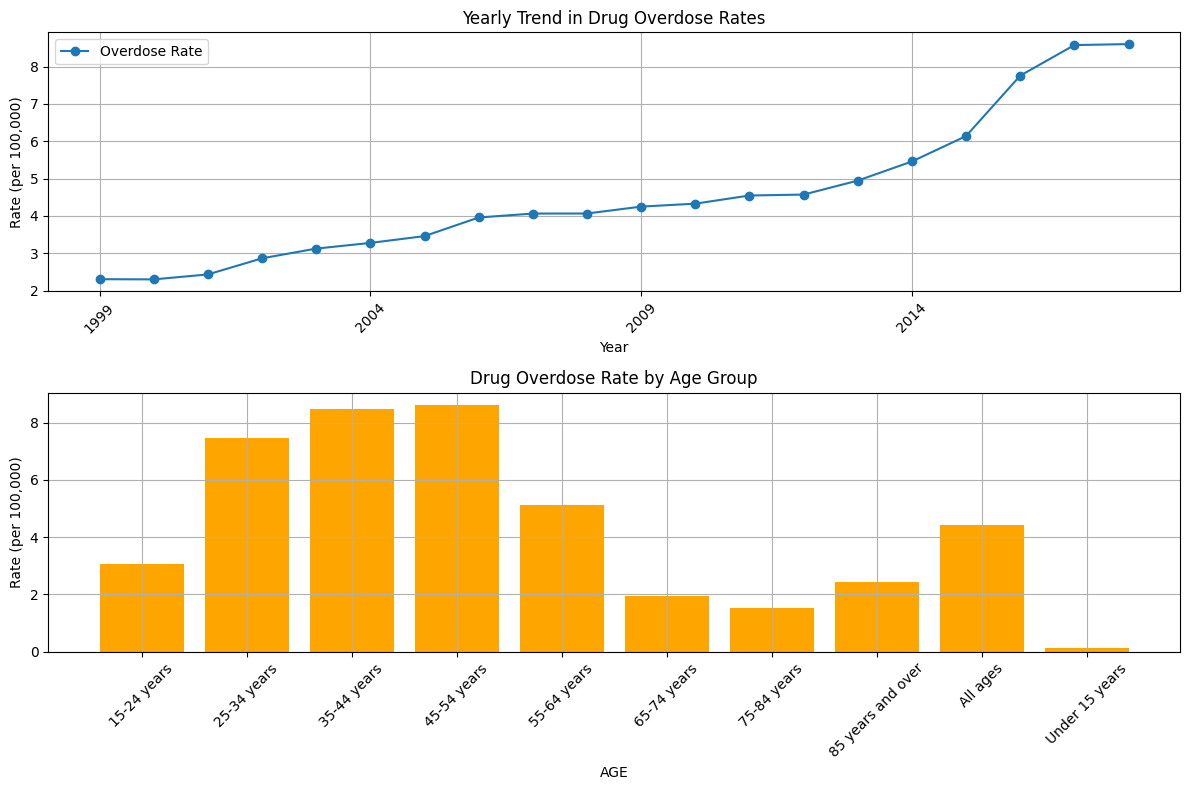

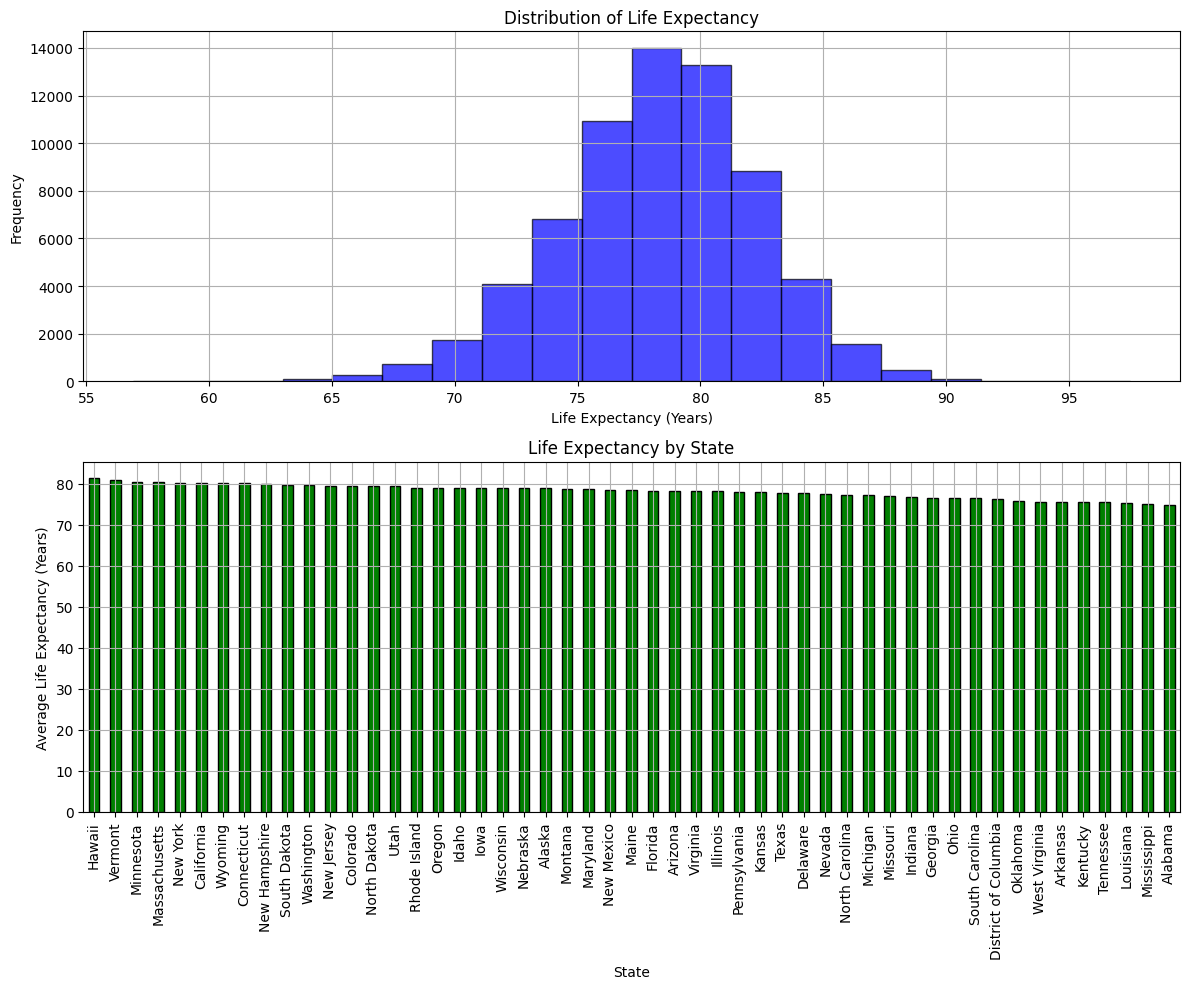

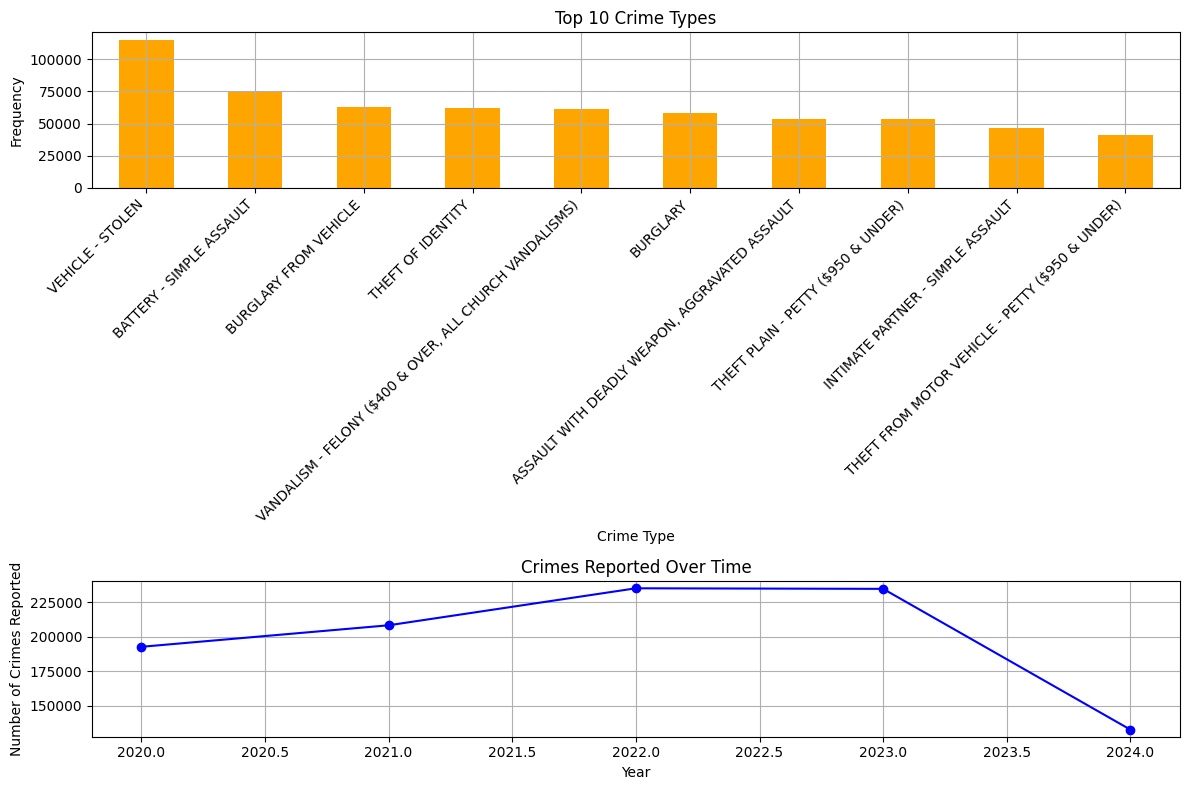

In [4]:
def plot_drug_overdose_trend(data):
    """
    Plots the yearly trend of drug overdose rates.
    """
    # Yearly trend in overdose rates
    yearly_trend = data.groupby('YEAR')['ESTIMATE'].mean()

    # Plotting yearly trend
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)  # Create a subplot with 2 rows, 1 column, plot on the 1st part
    plt.plot(yearly_trend.index, yearly_trend.values, marker='o', label='Overdose Rate')
    plt.title('Yearly Trend in Drug Overdose Rates')
    plt.xlabel('Year')
    plt.ylabel('Rate (per 100,000)')
    plt.grid(True)
    plt.legend()
    plt.xticks(ticks=yearly_trend.index[::5], rotation=45)

    # Panel by Age - Plotting overdose rates by age
    plt.subplot(2, 1, 2)  # Plot on the 2nd part of the subplot
    age_group_trend = data.groupby('AGE')['ESTIMATE'].mean()

    # Plotting by age
    plt.bar(age_group_trend.index, age_group_trend.values, color='orange')
    plt.title('Drug Overdose Rate by Age Group')
    plt.xlabel('AGE')
    plt.ylabel('Rate (per 100,000)')
    plt.grid(True)
    plt.xticks(rotation=45)

    # Display both plots
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()


def plot_life_expectancy_distribution(data):
    """
    Plots the distribution of life expectancy and life expectancy by state.
    """
    # Plotting the distribution of life expectancy
    plt.figure(figsize=(12, 10))

    # First plot: Distribution of life expectancy
    plt.subplot(2, 1, 1)  # Plot on the first subplot
    plt.hist(data['Life Expectancy'], bins=20, alpha=0.7, color='blue', edgecolor='black')
    plt.title('Distribution of Life Expectancy')
    plt.xlabel('Life Expectancy (Years)')
    plt.ylabel('Frequency')
    plt.grid(True)

    # Second plot: Life expectancy by state
    plt.subplot(2, 1, 2)  # Plot on the second subplot
    life_expectancy_by_state = data.groupby('State')['Life Expectancy'].mean()

    # Plotting life expectancy by state
    life_expectancy_by_state.sort_values(ascending=False).plot(kind='bar', color='green', edgecolor='black')
    plt.title('Life Expectancy by State')
    plt.xlabel('State')
    plt.ylabel('Average Life Expectancy (Years)')
    plt.xticks(rotation=90)
    plt.grid(True)

    # Display both plots
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()


def plot_crime_by_type(data):

    #Plots the distribution of crimes by type and crimes reported over time.

    # Count the occurrences of each crime type (from 'Crm Cd Desc')
    crime_by_type = data['Crm Cd Desc'].value_counts().head(10)  # Top 10 crime types

    # Plotting the top 10 crime types
    plt.figure(figsize=(12, 8))

    # First subplot: Top 10 crime types
    plt.subplot(2, 1, 1)
    crime_by_type.plot(kind='bar', color='orange')
    plt.title('Top 10 Crime Types')
    plt.xlabel('Crime Type')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability

    # Second subplot: Crimes reported over time (by year)
    plt.subplot(2, 1, 2)

    # Ensure 'Date Rptd' is a datetime type
    data['Date Rptd'] = pd.to_datetime(data['Date Rptd'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')

    # Extract the year from the 'Date Rptd' and group by year to count occurrences
    crimes_by_year = data.groupby(data['Date Rptd'].dt.year).size()

    # Plotting crimes reported over time
    crimes_by_year.plot(kind='line', marker='o', color='blue')
    plt.title('Crimes Reported Over Time')
    plt.xlabel('Year')
    plt.ylabel('Number of Crimes Reported')
    plt.grid(True)

    # Display both plots
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Load preprocessed datasets
    drug_overdose_data = pd.read_csv("drug_overdose_preprocessed.csv")
    life_expectancy_data = pd.read_csv("life_expectancy_preprocessed.csv")
    crime_data = pd.read_csv("crime_data_preprocessed.csv")

    # Generate visualizations
    plot_drug_overdose_trend(drug_overdose_data)
    plot_life_expectancy_distribution(life_expectancy_data)
    plot_crime_by_type(crime_data)
